<a href="https://www.kaggle.com/code/ranaibrahim22/ranaibrahim-basmalaahmed-aigeneratedvshuman?scriptVersionId=248798639" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# اول محاولة  

In [1]:
import os
import pandas as pd

BASE_DIR = '/kaggle/input/ai-vs-human-generated-dataset'
train_csv = os.path.join(BASE_DIR, "train.csv")
df = pd.read_csv(train_csv)
df["file_path"] = df["file_name"].apply(lambda x: os.path.join(BASE_DIR, x))

df.head()


,Unnamed: 0,file_name,label,file_path
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,/kaggle/input/ai-vs-human-generated-dataset/tr...
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,/kaggle/input/ai-vs-human-generated-dataset/tr...
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,/kaggle/input/ai-vs-human-generated-dataset/tr...
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,/kaggle/input/ai-vs-human-generated-dataset/tr...
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,/kaggle/input/ai-vs-human-generated-dataset/tr...


In [2]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks


2025-07-04 10:29:45.459020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751624985.918668      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751624986.035182      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)

In [4]:
def preprocess(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df["file_path"], train_df["label"]))
train_ds = train_ds.map(preprocess).shuffle(512).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df["file_path"], val_df["label"]))
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1751625011.511153      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751625011.511932      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)


In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(train_ds, validation_data=val_ds, epochs=5,
          callbacks=[early_stop, checkpoint])


Epoch 1/5


I0000 00:00:1751625040.609136      97 service.cc:148] XLA service 0x79f160003990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751625040.611159      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751625040.611178      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751625042.585209      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2249 ━━━━━━━━━━━━━━━━━━━━ 1:54 51ms/step - accuracy: 0.5156 - loss: 0.7371   

I0000 00:00:1751625053.175914      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2249/2249 ━━━━━━━━━━━━━━━━━━━━ 292s 117ms/step - accuracy: 0.9076 - loss: 0.2191 - val_accuracy: 0.9462 - val_loss: 0.1290
Epoch 2/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 100s 44ms/step - accuracy: 0.9490 - loss: 0.1281 - val_accuracy: 0.9546 - val_loss: 0.1148
Epoch 3/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9605 - loss: 0.0994 - val_accuracy: 0.9575 - val_loss: 0.1128
Epoch 4/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9687 - loss: 0.0815 - val_accuracy: 0.9570 - val_loss: 0.1113
Epoch 5/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 99s 44ms/step - accuracy: 0.9750 - loss: 0.0678 - val_accuracy: 0.9620 - val_loss: 0.1083


# Stage 2 – Unfreeze & Fine-tune 

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # freeze early layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(train_ds, validation_data=val_ds, epochs=5,
          callbacks=[early_stop, checkpoint])


Epoch 1/5


E0000 00:00:1751625738.410060      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751625738.551205      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2247/2249 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.2038

E0000 00:00:1751625852.195838      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751625852.341790      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2249/2249 ━━━━━━━━━━━━━━━━━━━━ 166s 59ms/step - accuracy: 0.9374 - loss: 0.2038 - val_accuracy: 0.9573 - val_loss: 0.1268
Epoch 2/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 113s 50ms/step - accuracy: 0.9678 - loss: 0.0891 - val_accuracy: 0.9642 - val_loss: 0.1052
Epoch 3/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 113s 50ms/step - accuracy: 0.9730 - loss: 0.0695 - val_accuracy: 0.9677 - val_loss: 0.0919
Epoch 4/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 113s 50ms/step - accuracy: 0.9777 - loss: 0.0583 - val_accuracy: 0.9701 - val_loss: 0.0847
Epoch 5/5
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 111s 49ms/step - accuracy: 0.9797 - loss: 0.0544 - val_accuracy: 0.9720 - val_loss: 0.0802


In [12]:
def preprocess_test(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img


In [10]:
test_csv = os.path.join(BASE_DIR, "test.csv")
test_df = pd.read_csv(test_csv)
test_df["file_path"] = test_df["id"].apply(lambda x: os.path.join(BASE_DIR, x))


# Build test dataset
test_ds = tf.data.Dataset.from_tensor_slices(test_df["file_path"])
test_ds = test_ds.map(lambda x: preprocess(x, 0)[0])  # discard label
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Load best model
model.load_weights("best_model.h5")

# Predict
preds = model.predict(test_ds)
labels = (preds > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": labels
})
submission.to_csv("submission.csv", index=False)



174/174 ━━━━━━━━━━━━━━━━━━━━ 67s 345ms/step


In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

In [ ]:
submission.head(20) # accuracy  -> .49

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


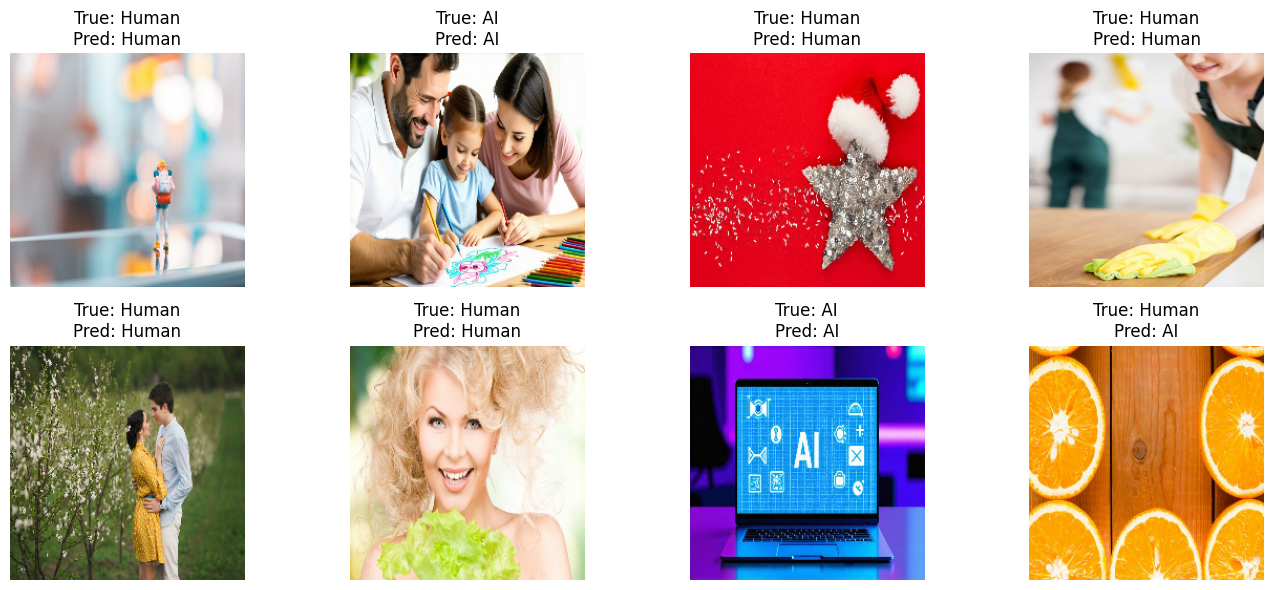

In [15]:
sample_df = val_df.sample(8, random_state=1).reset_index(drop=True)
sample_paths = sample_df["file_path"].tolist()

# Preprocess and predict
images = [preprocess_test(p) for p in sample_paths]
batch = tf.stack(images)
preds = model.predict(batch)
binary_preds = (preds > 0.5).astype(int)

# Plot with predicted labels
plt.figure(figsize=(14, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224)) / 255.0

    plt.subplot(2, 4, i+1)
    plt.imshow(img.numpy())
    true_label = "AI" if sample_df.iloc[i]["label"] == 1 else "Human"
    pred_label = "AI" if binary_preds[i] == 1 else "Human"
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# ثاني محاولة 

> غيرنا في البري بروسسنج والاوجمنتيشن 

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


**the data is balanced**

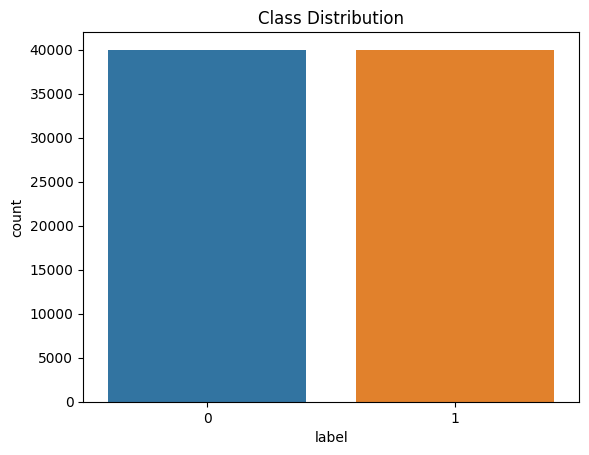

In [16]:
BASE_DIR = "/kaggle/input/ai-vs-human-generated-dataset"

df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df["file_path"] = df["file_name"].apply(lambda x: os.path.join(BASE_DIR, x))

# Plot class balance
sns.countplot(x="label", data=df)
plt.title("Class Distribution")
plt.show()


In [17]:
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)


# Augmented training preprocessing

In [18]:
def preprocess_train(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_saturation(img, 0.9, 1.1)
    img = tf.image.random_hue(img, 0.05)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

# Validation/test preprocessing (no augmentations)
def preprocess_val(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_df["file_path"], train_df["label"]))
train_ds = train_ds.shuffle(512).map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df["file_path"], val_df["label"]))
val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [19]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[early_stop, checkpoint])


Epoch 1/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 174s 67ms/step - accuracy: 0.8843 - loss: 0.2783 - val_accuracy: 0.9425 - val_loss: 0.1386
Epoch 2/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 131s 58ms/step - accuracy: 0.9265 - loss: 0.1801 - val_accuracy: 0.9487 - val_loss: 0.1246
Epoch 3/20
1235/2249 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.9328 - loss: 0.1666

In [ ]:
# Unfreeze last 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=13,
                         callbacks=[early_stop, checkpoint])


In [ ]:
# Reload best model
model.load_weights("best_model.h5")

# Predict on validation set
val_preds = model.predict(val_ds)
val_preds = (val_preds > 0.5).astype(int).flatten()
val_labels = val_df["label"].values

# Accuracy and F1
print("Validation Accuracy:", accuracy_score(val_labels, val_preds))
print("Classification Report:\n", classification_report(val_labels, val_preds))


In [ ]:
test_df = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))
test_df["file_path"] = test_df["id"].apply(lambda x: os.path.join(BASE_DIR, x))

def preprocess_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

test_ds = tf.data.Dataset.from_tensor_slices(test_df["file_path"])
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

preds = model.predict(test_ds)
labels = (preds > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    "id": test_df["id"],
    "label": labels
})
submission.to_csv("submission.csv", index=False)
submission.head(20)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv') # -> .45 

#   EfficientNetB3 ثالث محاولة باستخدام 

In [ ]:
import os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, mixed_precision
from tensorflow.keras.applications import EfficientNetB3
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Paths

# Split
tr_df, vl_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Preprocessing
def prep_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,3)
    img = tf.image.resize(img, [300,300])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img,0.2)
    img = tf.image.random_contrast(img,0.8,1.2)
    img = tf.image.random_saturation(img,0.8,1.2)
    return tf.keras.applications.efficientnet.preprocess_input(img), label

def prep_val(path,label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,3)
    img = tf.image.resize(img, [300,300])
    return tf.keras.applications.efficientnet.preprocess_input(img), label

BATCH=16
tr_ds = tf.data.Dataset.from_tensor_slices((tr_df.file_path, tr_df.label))
tr_ds = tr_ds.shuffle(1000).map(prep_aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)

vl_ds = tf.data.Dataset.from_tensor_slices((vl_df.file_path, vl_df.label))
vl_ds = vl_ds.map(prep_val, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Model
base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300,300,3))
base.trainable=False
model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Callbacks: one-cycle LR & early stop
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5  # Minimum learning rate
)
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best.h5', save_best_only=True, monitor='val_loss')
]

# Phase 1
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(tr_ds, validation_data=vl_ds, epochs=10, callbacks=cb)

# Fine-tune
base.trainable=True
for layer in base.layers[:-50]:
    layer.trainable=False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(tr_ds, validation_data=vl_ds, epochs=10, callbacks=cb)

# Evaluation
model.load_weights('best.h5')
vl_pred = (model.predict(vl_ds) > .5).astype(int).flatten()
print("Acc:", accuracy_score(vl_df.label, vl_pred))
print(classification_report(vl_df.label, vl_pred))




In [ ]:
tf.keras.optimizers.schedules.CosineDecayRestarts


In [ ]:
# Test & Submission
test = pd.read_csv(f"{BASE_DIR}/test.csv")
test['file_path'] = test['id'].apply(lambda x: os.path.join(BASE_DIR, x))
ts = tf.data.Dataset.from_tensor_slices(test['file_path']).map(lambda x: (tf.keras.applications.efficientnet.preprocess_input(tf.image.resize(tf.io.decode_jpeg(tf.io.read_file(x),3), [300,300])),0))
ts = ts.batch(BATCH).prefetch(tf.data.AUTOTUNE)
sub = (model.predict(ts)>0.5).astype(int).reshape(-1)
pd.DataFrame({'id': test.id, 'label': sub}).to_csv('submission.csv',index=False)

In [ ]:
submission.head(20)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv') # .42 سيئة اكتر 

# رابع محاولة مع تغيير في ال threshold

In [ ]:
# ========================
# 1. Imports and Setup
# ========================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Enable mixed precision
mixed_precision.set_global_policy("mixed_float16")

# ========================
# 2. Load Dataset
# ========================
BASE_DIR = "/kaggle/input/ai-vs-human-generated-dataset"
df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df["file_path"] = df["file_name"].apply(lambda x: os.path.join(BASE_DIR, x))
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)



In [ ]:

# ========================
# 3. Preprocessing with Augmentation
# ========================
IMG_SIZE = 300
BATCH_SIZE = 32

def preprocess_train(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.05)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

def preprocess_val(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df.file_path, train_df.label))
train_ds = train_ds.shuffle(1024).map(preprocess_train).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df.file_path, val_df.label))
val_ds = val_ds.map(preprocess_val).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



>  4. Model with EfficientNetB3
>  ========================

In [ ]:
# ========================
# 4. Model with EfficientNetB3
# ========================
base_model = tf.keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)


In [ ]:
# ========================
# 5. Phase 1 Training
# ========================
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop, checkpoint])

# ========================
# 6. Fine-Tuning
# ========================
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop, checkpoint])


In [ ]:

# ========================
# 7. Evaluation with F1 Score
# ========================
model.load_weights("best_model.h5")

val_preds = model.predict(val_ds).flatten()
val_labels = val_df.label.values
val_bin = (val_preds > 0.5).astype(int)

print("Accuracy:", accuracy_score(val_labels, val_bin))
print("F1 Score:", f1_score(val_labels, val_bin))
print(classification_report(val_labels, val_bin))


In [ ]:

# ========================
# 8. Predict on Test Set
# ========================
test_df = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))
test_df["file_path"] = test_df["id"].apply(lambda x: os.path.join(BASE_DIR, x))

def preprocess_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

test_ds = tf.data.Dataset.from_tensor_slices(test_df.file_path)
test_ds = test_ds.map(preprocess_test).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_preds = model.predict(test_ds).flatten()

# ========================
# 9. Dynamic Thresholding (Gaokui Trick)
# ========================
threshold = np.median(test_preds)
print(f"Dynamic threshold: {threshold:.4f}")

final_labels = (test_preds > threshold).astype(int)
submission = pd.DataFrame({'id': test_df["id"], 'label': final_labels})
submission.to_csv("submission.csv", index=False)
print("submission.csv saved.")
from IPython.display import FileLink
FileLink('submission.csv')


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Preview 9 predictions from test set
sample_paths = test_df.sample(9, random_state=42)["file_path"].values
sample_preds = model.predict(tf.data.Dataset.from_tensor_slices(sample_paths).map(preprocess_test).batch(9)).flatten()

plt.figure(figsize=(12, 12))
for i, path in enumerate(sample_paths):
    plt.subplot(3, 3, i+1)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    plt.imshow(img.numpy())
    plt.title(f"Predicted: {'AI' if sample_preds[i]>threshold else 'Human'}\nProb: {sample_preds[i]:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()
